In [203]:
import numpy as np

import gym
from gym import spaces
from gym.utils import seeding
from collections import defaultdict
import sys
import random
from tqdm import tqdm, tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline



  9%|▉         | 8936/100000 [00:21<00:56, 1598.75it/s]

In [176]:
def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]

def shuffle_deck(num_decks = 4):
    deck = [num_decks for i in range(9)]
    deck.append(num_decks * 4)
    return np.array(deck)

def usable_ace(hand):
    return 1 in hand and sum(hand) + 10 <= 21

def sum_hand(hand):
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)

def is_bust(hand):
    return sum_hand(hand) > 21

def score(hand):
    return 0 if is_bust(hand) else sum_hand(hand)

def cmp(a, b):
    return float(a > b) - float(a < b)

In [171]:
class BlackjackEnv(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Discrete(21)))
        self.natural = natural
        self.shuffle()
        self.points = np.array([[-1, 1, 1, 1, 1, 1, 0, 0, 0, -1]])
        self.reset()
    
    def shuffle(self):
        self.deck = shuffle_deck()
        
    def draw_card(self):
        card = np.random.choice(np.arange(1, 11), p=self.deck / self.deck.sum())
        self.deck[card - 1] -= 1
        if sum(self.deck) < 15:
            self.shuffle()
        return card
    
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]
        
    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:
            self.player.append(self.draw_card())
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        if action == 2:
            self.player.append(self.draw_card())
            done = True
            if is_bust(self.player):
                reward = -2.
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card()) 
                reward = cmp(score(self.player), score(self.dealer)) * 2.
        else:
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}
    
    def _get_obs(self):
        counter = shuffle_deck() - self.deck
        for i in self.dealer[1:]:
            counter[i - 1] -= 1
        counter = self.points.dot(counter)[0]
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), counter)
    
    def reset(self):
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        return self._get_obs()

In [172]:
env = BlackjackEnv(natural=True)

In [129]:
def plot_blackjack(V, ax1, ax2):
    player_sum = np.arange(12, 21 + 1)
    dealer_show = np.arange(1, 10 + 1)         
    usable_ace = np.array([False, True])
    state_values = np.zeros((len(player_sum), len(dealer_show), len(usable_ace)))
    for i, player in enumerate(player_sum):
        for j, dealer in enumerate(dealer_show):
            for k, ace in enumerate(usable_ace):
                state_values[i, j, k] = V.get((player, dealer, ace), 0)
    X, Y = np.meshgrid(player_sum, dealer_show)
    ax1.plot_wireframe(X, Y, state_values[:, :, 0])   
    ax2.plot_wireframe(X, Y, state_values[:, :, 1])
    for ax in ax1, ax2:    
        ax.set_zlim(-1, 1)
        ax.set_ylabel('player sum')
        ax.set_xlabel('dealer sum')
        ax.set_zlabel('state-value')

In [173]:
# возвращаем вероятность лучшего действия согласно epsilon
def get_probs(Q_s, epsilon, nA):
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

# обновляем Q
def update_Q(env, episode, Q, alpha, gamma):
    for s, a, r in episode:
        first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == s)
        G = sum([x[2]*(gamma**i) for i,x in enumerate(episode[first_occurence_idx:])])
        Q[s][a] = Q[s][a] + alpha*(G - Q[s][a])
    return Q

# policy
def mc_control_policy(Q, state, epsilon, nA):
    if state in Q:
        return np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA))
    else:
        return None
    
# новый генератор эпизодов
def generate_episode_from_Q(env, Q, epsilon, nA):
    episode = []
    state = env.reset()
    while True:
        
        action = mc_control_policy(Q, state, epsilon, nA)
        if action is None:
            action = env.action_space.sample()
            
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [204]:
# Monte-Carlo control
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99995, eps_min=0.01):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    cum_reward = []
    reward_hist = []
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        epsilon = max(epsilon*eps_decay, eps_min)
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        cum_reward.append(episode[-1][-1])
        Q = update_Q(env, episode, Q, alpha, gamma)
        
        if i_episode % 50000 == 0:
            avg_reward = []
            for i in tqdm_notebook(range(100000)):
                episode = generate_episode_from_Q(env, Q, .0, nA)
                avg_reward.append(episode[-1][-1])
            reward_hist.append(np.mean(avg_reward))
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q, cum_reward, reward_hist

In [207]:
policy, Q, cum_reward, reward_hist = mc_control(env, num_episodes = 1000000, alpha = 0.05, 
                                                gamma=.80, eps_start=1.0, eps_decay=.99995, eps_min=0.01)

Episode 50000/1000000.

Episode 100000/1000000.

Episode 150000/1000000.

Episode 200000/1000000.

Episode 250000/1000000.

Episode 300000/1000000.

Episode 350000/1000000.

Episode 400000/1000000.

Episode 450000/1000000.

Episode 500000/1000000.

Episode 550000/1000000.

Episode 600000/1000000.

Episode 650000/1000000.

Episode 700000/1000000.

Episode 750000/1000000.

Episode 800000/1000000.

Episode 850000/1000000.

Episode 900000/1000000.

Episode 950000/1000000.

Episode 1000000/1000000.

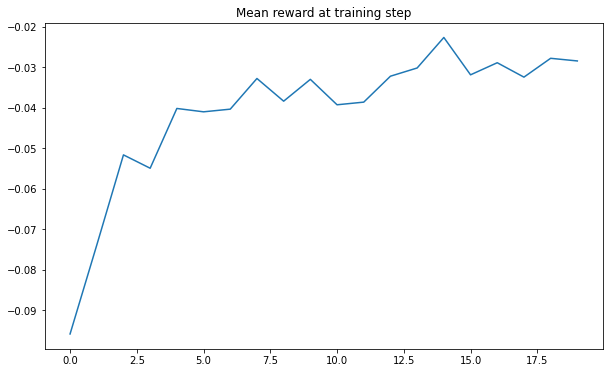

In [208]:
plt.figure(figsize = (10, 6))
plt.title('Mean reward at training step')
plt.plot(reward_hist)
plt.show()

In [209]:
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    current = Q[state][action]
    Qsa_next = Q[next_state][next_action] if next_state is not None else 0    
    target = reward + (gamma * Qsa_next)
    new_value = current + (alpha * (target - current))
    return new_value

def epsilon_greedy(Q, state, nA, eps):
    if random.random() > eps:
        return np.argmax(Q[state])
    else:
        return random.choice(np.arange(env.action_space.n))
    
def sarsa(env, num_episodes, alpha, gamma=1.0, epsmin=0.01):
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    cum_reward = []
    reward_hist = []
   
    for i_episode in range(1, num_episodes+1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        score = 0
        state = env.reset()
        
        eps = max(1.0 / i_episode, epsmin)
        action = epsilon_greedy(Q, state, nA, eps)
        
        while True:
            next_state, reward, done, info = env.step(action)
            score += reward
            if not done:
                next_action = epsilon_greedy(Q, next_state, nA, eps)
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward, next_state, next_action)
                
                state = next_state
                action = next_action
            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward)
                cum_reward.append(reward)
                break
        if i_episode % 50000 == 0:
            avg_reward = []
            for i in tqdm_notebook(range(100000)):
                episode = generate_episode_from_Q(env, Q, .0, nA)
                avg_reward.append(episode[-1][-1])
            reward_hist.append(np.mean(avg_reward))
    return Q, cum_reward, reward_hist

In [ ]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa, cum_reward, reward_hist = sarsa(env, 5000000, 0.05, gamma=.2)

Episode 50000/5000000.

Episode 100000/5000000.

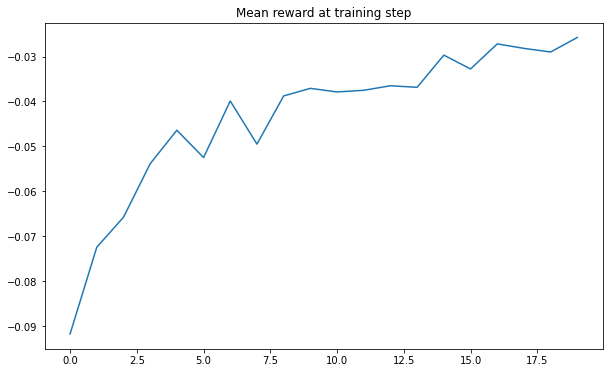

In [225]:
plt.figure(figsize = (10, 6))
plt.title('Mean reward at training step')
plt.plot(reward_hist)
plt.show()

plt.figure(figsize = (10, 6))
plt.title('Mean cumulative reward')
plt.plot(np.cumsum(cum_reward) / np.arange(1, 500001))
plt.show()
(np.cumsum(cum_reward) / np.arange(1, 500001))[-5:]